# Catégorisation automatique de questions

## Initialisation

In [29]:
# Standard libraries
import itertools
import os
import re
import sys

# External libraries
import bs4
import matplotlib 
import matplotlib.pyplot as plt
import nltk
import nltk.stem.porter
import numpy as np
import pandas as pd
import pickle
import pyLDAvis
import pyLDAvis.sklearn
import scipy
import seaborn as sns
import spacy
import sklearn as sk
import sklearn.decomposition
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_selection
import sklearn.model_selection
import sklearn.multiclass
import sklearn.multioutput
import sklearn.naive_bayes
import sklearn.svm
import string

FILENAME_1 = "P6 SO latest 50k.csv"
FILENAME_2 = "P6 SO penultimate 50k.csv"

DATA_FILE = "data/P6 all labels.dat"
DATA_FILE_SINGLE_LABEL = "data/P6 single label.dat"

CREATE_DATA_FILES = False

# Effacer les colonnes inutilisées pour libérer de la mémoire ?
DEL_UNUSED_COLS = True

# Ne pas exécuter les sections à temps de calcul élever
CALC_SLOW_SECTIONS = False

SEED = 1911

In [2]:
col_names = ['Id', 'Score', 'Body', 'Title', 'Tags']
files = (FILENAME_1, FILENAME_2)
df = pd.concat(pd.read_csv(f, usecols=col_names) for f in files)
print(f"Taille des données : {df.shape}")
df.head(10)

Taille des données : (99460, 5)


,Id,Score,Body,Title,Tags
0,57560001,0,<p>found the answer!</p>\n\n<pre><code>rdd = s...,NaN,NaN
1,57560002,1,<p>I am trying to get the S3 Bucket size in aw...,Python Script to get the size of the S3 Bucket...,<python><amazon-web-services><amazon-s3><boto3...
2,57560003,0,<p>I am trying to set up the virtual environme...,"The command "".\Scripts\activate"" is not working",<python>
3,57560005,0,"<p>As we all know, we can automagicaly generat...",Is Java annotation processor capable of removi...,<java><annotations><conditional-compilation>
4,57560006,0,<p>The GoDaddy package my friend got doesn't h...,Multer-sftp won't upload over port 21,<node.js><upload><sftp><multer>
5,57560007,0,<p>Maybe it works when you initialize the OnCl...,NaN,NaN
6,57560008,0,<p>I was coding these past two weeks and it wa...,Android studio all xml layout broke and now co...,<android><android-layout>
7,57560009,1,"<p>According to you document sample, <code>con...",NaN,NaN
8,57560010,3,"<p>Create a lookup table:</p>\n\n<p><a href=""h...",NaN,NaN
9,57560012,-1,<p>I have a table I queried from SQL:</p>\n\n<...,Pandas - transform SQL style dataframe to columns,<pandas>


In [3]:
print("Nombre de valeurs manquantes par colonne :")
df.isna().sum(axis=0)

Nombre de valeurs manquantes par colonne :


Id           0
Score        0
Body        49
Title    52054
Tags     52054
dtype: int64

In [4]:
mask = df['Tags'].isna()
print(f"Suppression de {sum(mask)} lignes.")
df = df[~mask]
print(f"Nouvelle taille des données : {df.shape}")

Suppression de 52054 lignes.
Nouvelle taille des données : (47406, 5)


## Analyse initiale

### Traitement des étiquettes

In [43]:
PREFIXES = ['.net', 'adfs', 'ag-grid', 'alexa', 'amazon', 
            'android', 'angular', 'ansible', 
            'apache', 'apex', 'apollo', r'asp\.net', 'aws', 'azure', 
            'bootstrap',
            'browser', r'c\+\+', 'c#', 'cassandra',
            'cocos2d', 'chrome', 'cloudera',
            'crystal-reports'
            'css', 'database', 'django', 
            'docker', 'ecma', 'elasticsearch', 'email', 'excel', 'facebook', 
            'firebase', 'firefox', 'flask', 'flutter', 'gcc', 'github', 
            'gitlab', 'git-', 'gmail', 'google-api', 'google-app', 
            'google-chrome', 'google-cloud', 'google-maps', 'google-play',
            'google-sheets', 'html', 'http', 'ios', 'iphone', 'laravel',
            'matlab', 'maven', 'mongo', 'mouse', 'mysql', 'npm',
            'oauth', 'oracle',
            'outlook', 'pandas', 'postgresql', 'python', 'react', 
            'scala', 'scikit', 'scipy', 'scrapy', 'selenium', 'serverless',
            'sharepoint', 'spring', 'sql-server', 'sqlite', 
            'ssh', 'swift', 'tensorflow',
            'ubuntu', 'unity', 'unix', 'visual-studio', 'vue', 
            'windows-server', 'wordpress',
            'xml', 'youtube']

def tokenize_tags(t):
    for prefix in PREFIXES:
        t = re.sub(r'\<' + prefix + r'[\w\d\.-]*\>', r'<' + prefix + r'>', t)
    # pour distinguer 'git' de 'github', 'gitlab', etc
    t = t.replace('git-', 'git') 
    # purement esthétique...
    t = t.replace(r'c\+\+', 'c++') 
    t = t.replace(r'asp\.net', 'asp.net') 
    tags_list = re.findall(r'\<(.*?)\>', t)   
    return tags_list

def raw_tokenize_tags(t):    
    tags_list = re.findall(r'\<(.*?)\>', t)   
    return tags_list    

In [6]:
print("*** Avant simplification")
cv = CountVectorizer(analyzer='word', tokenizer=raw_tokenize_tags, binary=True)
tags = cv.fit_transform(df['Tags'])
print(f"Nombre total d'étiquettes attribuées : {tags.sum()}")
print(f"Nombre d'étiquettes distinctes : {len(cv.get_feature_names())}")
print("*** Après simplification")
cv = CountVectorizer(analyzer='word', tokenizer=tokenize_tags, binary=True)
tags = cv.fit_transform(df['Tags'])
print(f"Nombre total d'étiquettes attribuées : {tags.sum()}")
print(f"Nombre d'étiquettes distinctes : {len(cv.get_feature_names())}")
print(f"Taille de la matrice de labels : {tags.shape}")
avg = tags.sum() / tags.shape[0]
print(f"Nombre moyen d'étiquettes par question: {avg:0.2f}")

*** Avant simplification
Nombre total d'étiquettes attribuées : 135343
Nombre d'étiquettes distinctes : 13040
*** Après simplification
Nombre total d'étiquettes attribuées : 125835
Nombre d'étiquettes distinctes : 11165
Taille de la matrice de labels : (47406, 11165)
Nombre moyen d'étiquettes par question: 2.65


In [7]:
print("Liste des étiquettes après simplification :")
" ".join(cv.get_feature_names())

Liste des étiquettes après simplification :


'.app .htaccess .mov .net .so 2d 2d-vector 2sxc 32-bit 32bit-64bit 32feet 360-degrees 360-virtual-reality 3d 3d-model 3d-secure 3dsmax 3dtouch 3g 3nf 3scale 4d 4gl 64-bit 68hc12 7zip 8-puzzle 80286 8051 a-star a2dp aabb aapt aar abac abap abaqus abbyy abc abp absolute absolute-path absolutelayout abstract abstract-base-class abstract-class abstract-data-type abstract-syntax-tree abstraction accelerometer acceptance-testing access access-denied access-modifiers access-rights access-token access-vba access-violation accessibility accessibilityservice accord.net accordion account account-kit accounting accumulate ace-editor aceoledb acfpro acl acm-icpc acr122 acra acrobat acrofields action action-filter actioncable actioncontroller actionlink actionmailer actions-on-google actionscript-3 actiontext actionviewhelper activation-function activator active-directory active-model-serializers active-window activeadmin activecampaign activemq activemq-artemis activerecord activerecord-import acti

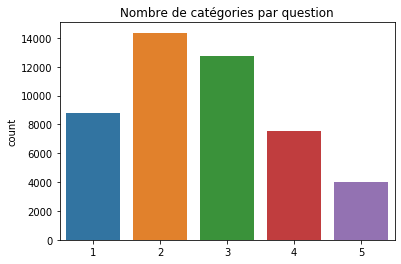

In [8]:
num_labels = np.squeeze(np.asarray(tags.sum(axis=1)))
axes = sns.countplot(num_labels);
axes.set_title("Nombre de catégories par question");

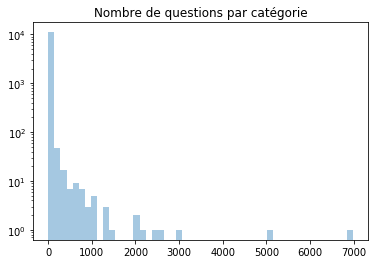

In [9]:
tags_s = pd.Series(np.squeeze(np.asarray(tags.sum(axis=0))), 
                   index=cv.get_feature_names())
tags_s.sort_values(inplace=True, ascending=False)
axes = sns.distplot(tags_s, kde=False);
axes.set_yscale('log');
axes.set_title("Nombre de questions par catégorie");

### Suppression des labels rares

In [10]:
TRESHOLD = 100
count = sum(np.sum(tags.toarray(), axis=0, keepdims=False) <= TRESHOLD)
print(f"Nombre de labels apparaissant moins de {TRESHOLD} fois : {count}")

Nombre de labels apparaissant moins de 100 fois : 11015


In [11]:
print(f"Taille de la matrice des labels avant suppression : {tags.shape}")
keep_cols = np.sum(tags.toarray(), axis=0, keepdims=False) > TRESHOLD
tags = tags[:, keep_cols]
print(f"Taille de la matrice des labels après suppression : {tags.shape}")

Taille de la matrice des labels avant suppression : (47406, 11165)
Taille de la matrice des labels après suppression : (47406, 150)


In [12]:
deleted = list(itertools.compress(cv.get_feature_names(), ~keep_cols))
print(f"{len(deleted)} labels supprimés :")
print(" ".join(deleted))

11015 labels supprimés :


.app .htaccess .mov .so 2d 2d-vector 2sxc 32-bit 32bit-64bit 32feet 360-degrees 360-virtual-reality 3d 3d-model 3d-secure 3dsmax 3dtouch 3g 3nf 3scale 4d 4gl 64-bit 68hc12 7zip 8-puzzle 80286 8051 a-star a2dp aabb aapt aar abac abap abaqus abbyy abc abp absolute absolute-path absolutelayout abstract abstract-base-class abstract-class abstract-data-type abstract-syntax-tree abstraction accelerometer acceptance-testing access access-denied access-modifiers access-rights access-token access-vba access-violation accessibility accessibilityservice accord.net accordion account account-kit accounting accumulate ace-editor aceoledb acfpro acl acm-icpc acr122 acra acrobat acrofields action action-filter actioncable actioncontroller actionlink actionmailer actions-on-google actionscript-3 actiontext actionviewhelper activation-function activator active-directory active-model-serializers active-window activeadmin activecampaign activemq activemq-artemis activerecord activerecord-import activesupp

In [13]:
keep_rows = np.sum(tags.toarray(), axis=1, keepdims=False) > 0
count = sum(~keep_rows)
print(f"Nombre de lignes sans étiquettes : {count} sur {len(keep_rows)}")
df = df[keep_rows]
tags = tags[keep_rows, :]
print(f"Nouvelle taille des données : {df.shape}")
print(f"Nouvelle taille de la matrice de labels : {tags.shape}")

Nombre de lignes sans étiquettes : 5310 sur 47406
Nouvelle taille des données : (42096, 5)
Nouvelle taille de la matrice de labels : (42096, 150)


In [14]:
features = list(itertools.compress(cv.get_feature_names(), keep_cols))
print(f"{len(features)} labels restants :")
print(" ".join(features))

150 labels restants :
.net ajax algorithm amazon android angular ansible apache api arrays asp.net asynchronous authentication aws azure bash beautifulsoup bootstrap c c# c++ class css csv dart database dataframe date datetime deep-learning dictionary django docker dplyr ecma elasticsearch eloquent entity-framework excel express facebook file firebase flask flutter for-loop forms function ggplot2 git github go google-app google-chrome google-cloud google-maps google-sheets gradle graphql hibernate html http if-statement image ionic-framework ionic4 ios java javascript jenkins jestjs jpa jquery json keras kotlin kubernetes laravel linux list logging loops machine-learning macos matplotlib maven mongo multithreading mysql nginx node.js npm numpy object opencv oracle pandas pdf performance php postgresql powershell pyspark python qt r react redux regex rest ruby ruby-on-rails rust scala scikit selenium shell shiny sorting spring sql sql-server sqlite ssl string svg swift symfony tensorflo

### Extraction du premier label (pour classement monolabel)

In [15]:
def get_first_tag(s):
    tags = tokenize_tags(s)
    return tags[0]

df['Tag'] = df['Tags'].apply(get_first_tag)
df['TagCode'] = df['Tag'].factorize()[0]
tags_df = df[['Tag', 'TagCode']].drop_duplicates().sort_values('TagCode')
tag_to_id = dict(tags_df.values)
id_to_tag = dict(tags_df[['TagCode', 'Tag']].values)
df[['Tag', 'TagCode', 'Tags']].head(10)

,Tag,TagCode,Tags
1,python,0,<python><amazon-web-services><amazon-s3><boto3...
2,python,0,<python>
3,java,1,<java><annotations><conditional-compilation>
4,node.js,2,<node.js><upload><sftp><multer>
6,android,3,<android><android-layout>
9,pandas,4,<pandas>
14,python,0,<python><bash><git><anaconda><conda>
15,api,5,<api><filenet-p8><filenet-process-engine>
17,vue,6,<vue.js><axios>
19,flutter,7,<flutter><dart><flutter-layout>


In [16]:
TRESHOLD = 100
tag_counts = df['Tag'].value_counts() 
print(f"Nombre de labels uniques : {len(tag_counts)}")
print(f"Nombre de labels apparaissant moins de {TRESHOLD} fois : "
      f"{sum(tag_counts < TRESHOLD)}")

Nombre de labels uniques : 470
Nombre de labels apparaissant moins de 100 fois : 413


In [17]:
del_labels = tag_counts[tag_counts < TRESHOLD].index.values
del_mask = df['Tag'].isin(del_labels.tolist())
print(f"Nombre de lignes à effacer : {sum(del_mask)} sur {len(del_mask)}")

Nombre de lignes à effacer : 3375 sur 42096


In [18]:
print("Labels restant après simplification :")
" ".join(tag_counts[tag_counts >= TRESHOLD].index.values)

Labels restant après simplification :


'python javascript java c# php android r react c++ angular html node.js sql ios excel mysql c swift flutter django azure amazon spring css laravel ruby-on-rails jquery asp.net sql-server docker apache typescript linux vue json wordpress powershell git visual-studio regex bash scala mongo firebase arrays google-app go postgresql windows oracle kubernetes vb.net google-cloud elasticsearch .net tensorflow ruby'

### Préparation du texte

In [19]:
stop_words = set(nltk.corpus.stopwords.words("english"))
print(f"Nombre de mots à ignorer (NLTK) : {len(stop_words)}")
new_words = ["using", "trying", "running", "want", "except", "guys", "get", 
             "code", "run", "might", "tried", "whenever", "current", "gives", 
             "name", "try", "must", "know", "looks", "problem", "problems",
             "anyone", "without", "the", "error", "popular", "really"]
stop_words = stop_words.union(new_words)
#stop_words = stop_words.union(list(string.punctuation))
print(f"Nombre total de mots à ignorer : {len(stop_words)}")

Nombre de mots à ignorer (NLTK) : 179
Nombre total de mots à ignorer : 205


In [20]:
len(sklearn.feature_extraction.stop_words.ENGLISH_STOP_WORDS)

318

In [21]:
# avant suppression des chiffres, nous préservons certains termes
replace_list = [('vt100', 'vthundred'),
                ('port 25', 'porttwentyfive'),
                ('port 8000', 'porteightthousand'),
                ('port 8080', 'porteightyeighty'),
                ('2D', 'twodim'),
                ('3D', 'threedim'),
                ('vt100', 'vthundred'),
                ('c#', 'csharp'),
                ('in c', 'clanguage'),
                ('c++11', 'cppeleven'),
                ('c++', 'cpp'),
                ('g++', 'gpp'),
                ('s3', 'sthree'),
                ('x64', 'xsixtyfour'),
                ('i386', 'ithreeeightsix')
               ]

regex_list = [(r'\br\b', 'RSoftware'),
              (r'\s.net\b', 'dotnet')]

def replace_words_containing_non_alphas(s):
    for w1, w2 in replace_list:
        s = s.replace(w1, w2)
    for w1, w2 in regex_list:
        s = re.sub(w1, w2, s)
    return s
                
s = "The SMTP protocol is assigned the port 25."
replace_words_containing_non_alphas(s)

'The SMTP protocol is assigned the porttwentyfive.'

In [53]:
def tokenize_text(s): 
    # Suppression des balises HTML
    cleaner = lambda text: bs4.BeautifulSoup(text, 'html.parser').get_text()
    s = cleaner(s).lower()
    # Élimine chiffres et caractères spéciaux des mots importants
    s = replace_words_containing_non_alphas(s)
    # Suppression des caractères non alphabétiques
    s = re.sub(r'[^a-zA-Z]', ' ', s)    
    # Suppression des mots de 1 ou 2 lettres
    s = re.sub(r'\b[a-z]{1,2}\b', '', s)
    # Suppression des mots dans `stop_words`
    s = [w for w in nltk.tokenize.word_tokenize(s) if w not in stop_words]    
    # Lemmatisation
    stemmer = nltk.stem.porter.PorterStemmer(mode='NLTK_EXTENSIONS')
    stemmed = []
    # lemmatizer = nltk.stem.WordNetLemmatizer() 
    for item in s:
        #stemmed.append(lemmatizer.lemmatize(item, pos='v'))
        stemmed.append(stemmer.stem(item))
    return ' '.join(stemmed)    

example = "The time zone (+10) was configured under Regional Settings."\
          "C++11 is a version of the standard for the language C++."\
          "The R website is http://www.r-project.net. "\
          ".NET Framework (pronounced as dot net) is a software framework"
tokenize_text(example)

'time zone configur region set cppeleven version standard languag cpp rsoftwar websit http www rsoftwar project net dotnet framework pronounc dot net softwar framework'

In [54]:
df['Text'] = (df['Title'] + ' ' + df['Body']).apply(tokenize_text)
df[['Title', 'Body', 'Text']].to_csv('processed_text.csv', header=False)
df.head(20)

KeyError: 'Title'

## Sauvegarde

In [24]:
df1 = df[~del_mask].copy()
if DEL_UNUSED_COLS:
    df1.drop(columns=['Score', 'Body', 'Title', 'Tags'], 
             inplace=True, 
             errors='ignore')
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38721 entries, 1 to 49457
Data columns (total 4 columns):
Id         38721 non-null int64
Tag        38721 non-null object
TagCode    38721 non-null int64
Text       38721 non-null object
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [25]:
# Suppression des colonnes inutilisées
if DEL_UNUSED_COLS:
    df.drop(columns=['Score', 'Body', 'Title', 'Tag', 'TagCode'], 
            inplace=True, 
            errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42096 entries, 1 to 49457
Data columns (total 3 columns):
Id      42096 non-null int64
Tags    42096 non-null object
Text    42096 non-null object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [41]:
if CREATE_DATA_FILES:
    data = (df, tags, id_to_tag, features)
    pickle.dump(data, open(DATA_FILE, 'wb'))
    size = os.path.getsize(DATA_FILE) / 1024**2
    print(f"Taille du fichier : {size:.1f} MB")
else:
    print("Sauvegarde désactivée.")

Taille du fichier : 41.7 MB


In [42]:
if CREATE_DATA_FILES:
    pickle.dump(df1, open(DATA_FILE_SINGLE_LABEL, 'wb'))
    size = os.path.getsize(DATA_FILE_SINGLE_LABEL) / 1024**2
    print(f"Taille du fichier : {size:.1f} MB")
else:
    print("Sauvegarde désactivée.")

Taille du fichier : 37.2 MB


In [28]:
# Arrêt de l'exécution
x = 1 /0

ZeroDivisionError: division by zero

## Classement mono-label

### Représentation des messages en matrice TFIDF

In [ ]:
# On ne conserve que les labels fréquents
df1 = df[~del_mask].copy()
# Utilisation de `min_df` nécessaire pour réduire la quantité de mots
fv = TfidfVectorizer(analyzer='word', ngram_range=(1,2), 
                     min_df=50, stop_words='english')
text_tfidf = fv.fit_transform(df1['Text'])
print(f"Taille de la matrice Tfidf : {text_tfidf.shape}")

In [ ]:
print(f"{len(fv.stop_words_)} termes exclus")
#print(" ".join(fv.stop_words_))

In [ ]:
X = text_tfidf
y = df1['TagCode']
X_tr, X_t, y_tr, y_t = sk.model_selection.train_test_split(X, y, 
                                                           test_size=0.3, 
                                                           random_state=SEED)
X_tr.shape, y_tr.shape, X_t.shape, y_t.shape

### Mots et bi-grammes les plus corrélés avec chaque catégorie

In [ ]:
n_terms = 3
for label, id in [(id_to_tag[id], id) for id in df1['TagCode'].unique()]:
    chi2 = sk.feature_selection.chi2(text_tfidf.toarray(), 
                                     df1['TagCode'] == id)
    indices = np.argsort(chi2[0])
    feature_names = np.array(fv.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]        
    print(label, ":", unigrams[-n_terms:], bigrams[-n_terms:])

### Modèle bayésien naïf multinomial 

In [ ]:
model = sk.naive_bayes.MultinomialNB()
model.fit(X_tr, y_tr)

In [ ]:
def print_scores(y, y_pred):
    score = sk.metrics.recall_score(y, y_pred, average='micro')    
    print(f"Rappel = {score:0.2f}")
    score = sk.metrics.precision_score(y, y_pred, average='micro')
    print(f"Précision = {score:0.2f}")
    score = sk.metrics.f1_score(y, y_pred, average='micro')
    print(f"F1 = {score:0.2f}")    
    score = sk.metrics.accuracy_score(y, y_pred)    
    print(f"Justesse = {score:0.2f}")    
    print()

In [ ]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

In [ ]:
names = [id_to_tag[i] for i in y_t.sort_values().unique()]
print(sk.metrics.classification_report(y_t, y_pred, 
                                       target_names=names))

In [ ]:
# Example
row = 0
v = text_tfidf[row, :]
predicted = model.predict(v)[0]
expected = df1.iloc[row]['TagCode']
print(f"Labels prédit et attendu pour ligne {row} : {predicted, expected}")
df.iloc[row]

### Régression logistique

In [ ]:
model = sk.linear_model.LogisticRegression(multi_class='multinomial', 
                                           solver='sag')
model.fit(X_tr, y_tr)

In [ ]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

In [ ]:
names = [id_to_tag[i] for i in y_t.sort_values().unique()]
print(sk.metrics.classification_report(y_t, y_pred, 
                                       target_names=names))

### SVM linéaire

#### Optimisation des hyperparamètres

In [ ]:
base = sk.svm.LinearSVC(dual=False, random_state=SEED)
grid = {'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000, 2000, 5000]
       }
model = sk.model_selection.GridSearchCV(base,
                                        param_grid=grid,
                                        cv=5,
                                        n_jobs=-1)
if CALC_SLOW_SECTIONS:
    model.fit(X_tr, y_tr)
    model.best_params_

Résultats : {'C': 1, 'penalty': 'l1', 'max_iter': 1000}

#### Entraînement du modèle

In [ ]:
model = sk.svm.LinearSVC(C=1.0, penalty='l1', max_iter=1000, dual=False)
model.fit(X_tr, y_tr)

In [ ]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)


## Classement multilabel

In [ ]:
# Exception pour arrêter le calcul
x = 1/0 

### Réduction de dimension de la matrice documents-termes
Pas nécessaire pour l'instant, mais à faire quand même

In [ ]:
fv = TfidfVectorizer(analyzer='word', min_df=20, max_df=0.3, 
                     ngram_range=(1, 1))
text_tfidf = fv.fit_transform(df['Text'])
print(f"Taille de la matrice TFIDF : {text_tfidf.shape}")
X = text_tfidf
y = tags
X_tr, X_t, y_tr, y_t = sk.model_selection.train_test_split(X, y, 
                                                           test_size=0.3, 
                                                           random_state=SEED)
X_tr.shape, y_tr.shape, X_t.shape, y_t.shape

In [ ]:
print(f"{len(fv.stop_words_)} termes exclus")
#print(" ".join(fv.stop_words_))

### Classement indépendant par catégorie

#### Modèle MultinomialNB

In [ ]:
y_pred_t = scipy.sparse.lil_matrix(y_t.shape)
y_pred_tr = scipy.sparse.lil_matrix(y_tr.shape)
model = sk.naive_bayes.MultinomialNB(fit_prior=True, 
                                     class_prior=None)
for i, feature in enumerate(features):
    y_label_tr = y_tr[:, i].toarray().reshape(-1)
    y_label_t = y_t[:, i].toarray().reshape(-1)
    model.fit(X_tr.toarray(), y_label_tr)    
    y_pred1_tr = model.predict(X_tr)
    y_pred1_t = model.predict(X_t)
    score_tr = sk.metrics.recall_score(y_label_tr, y_pred1_tr)
    score_t = sk.metrics.recall_score(y_label_t, y_pred1_t)
    y_pred_t[:, i] = y_pred1_t.reshape(-1, 1)
    y_pred_tr[:, i] = y_pred1_tr.reshape(-1, 1)
    print(f"{feature} ({score_tr*100:0.0f}%, {score_t*100:0.0f}%)", end=' ')

In [ ]:
print_scores(y_t, y_pred_t)

Rappel = 0.05
Précision = 0.78
Justesse = 0.09
F1 = 0.02

#### Régression logistique

In [ ]:
filename = "data/P6-MultiLabelLogisticRegressionOutput.sav"

if CALC_SLOW_SECTIONS:
    y_pred_t = scipy.sparse.lil_matrix(y_t.shape)
    y_pred_tr = scipy.sparse.lil_matrix(y_tr.shape)
    model = sk.linear_model.LogisticRegression(multi_class='multinomial', 
                                               solver='sag', n_jobs=4)

    for i, f in enumerate(features):
        y_label_tr = y_tr[:, i].toarray().reshape(-1)
        y_label_t = y_t[:, i].toarray().reshape(-1)
        model.fit(X_tr.toarray(), y_label_tr)    
        y_pred1_tr = model.predict(X_tr)
        y_pred1_t = model.predict(X_t)
        score_tr = sk.metrics.recall_score(y_label_tr, y_pred1_tr)
        score_t = sk.metrics.recall_score(y_label_t, y_pred1_t)
        y_pred_t[:, i] = y_pred1_t.reshape(-1, 1)
        y_pred_tr[:, i] = y_pred1_tr.reshape(-1, 1)
        print(f"{f} ({score_tr*100:0.0f}%, {score_t*100:0.0f}%)", end=' ')
        data = (y_pred_tr, y_pred_t)
        pickle.dump(data, open(filename, 'wb'))
else:
    y_pred_tr, y_pred_t = pickle.load(open(filename, 'rb'))
    print(y_pred_tr.shape, y_pred_t.shape)

In [ ]:
print("*** Scores sur données d'entraînement")
print_scores(y_tr, y_pred_tr)
print("*** Scores sur données de test :")
print_scores(y_t, y_pred_t)

#### SVM linéaire

In [ ]:
i = 0
f = features[i]
base = sk.svm.LinearSVC(dual=False, random_state=SEED)
grid = {'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'max_iter': [1000, 2000, 5000]
       }
model = sk.model_selection.GridSearchCV(base,
                                        param_grid=grid,
                                        cv=5,
                                        n_jobs=1)
y_label_tr = y_tr[:, i].toarray().reshape(-1)
model.fit(X_tr.toarray(), y_label_tr)    
model.best_params_

In [ ]:
y_pred_t = scipy.sparse.lil_matrix(y_t.shape)
y_pred_tr = scipy.sparse.lil_matrix(y_tr.shape)
model = sk.svm.LinearSVC(C=1.0, penalty='l1', max_iter=1000, 
                         multi_class='ovr', dual=False)

for i, f in enumerate(features):
    y_label_tr = y_tr[:, i].toarray().reshape(-1)
    y_label_t = y_t[:, i].toarray().reshape(-1)
    model.fit(X_tr.toarray(), y_label_tr)    
    y_pred1_tr = model.predict(X_tr)
    y_pred1_t = model.predict(X_t)
    score_tr = sk.metrics.recall_score(y_label_tr, y_pred1_tr)
    score_t = sk.metrics.recall_score(y_label_t, y_pred1_t)
    y_pred_t[:, i] = y_pred1_t.reshape(-1, 1)
    y_pred_tr[:, i] = y_pred1_tr.reshape(-1, 1)
    print(f"{f} ({score_tr*100:0.0f}%, {score_t*100:0.0f}%)", end=' ')
    data = (y_pred_tr, y_pred_t)
    pickle.dump(data, open(filename, 'wb'))

In [ ]:
print("*** Scores sur données d'entraînement")
print_scores(y_tr, y_pred_tr)
print("*** Scores sur données de test :")
print_scores(y_t, y_pred_t)

### Utilisation de OneVsRestClassifier

In [ ]:
base = sk.linear_model.LogisticRegression(multi_class='multinomial',
                                          solver='sag',
                                          n_jobs=-1)
model = sk.multiclass.OneVsRestClassifier(base)
model.fit(X_tr.toarray(), y_tr)

In [ ]:
print("*** Scores sur données d'entraînement")
y_pred_tr = model.predict(X_tr)
print_scores(y_tr, y_pred_tr)
print("*** Scores sur données de test :")
y_pred_t = model.predict(X_t)
print_scores(y_t, y_pred_t)

Mêmes résultats que précédemment.

In [ ]:
y_correct = y_t.toarray()
for row in range(30):
    y_pred_tr_row = y_pred_t[row, :].toarray()[0]
    pred = [id_to_tag[i] for i in np.where(y_pred_tr_row == 1)[0] ]
    labels = [id_to_tag[i] for i in np.where(y_correct[row, :] == 1)[0] ]
    print(row, pred, labels)

### Classement en chaîne (ClassifierChain)

#### Régression logistique

In [ ]:
filename = "data/P6-ClassifierChain.sav"

if CALC_SLOW_SECTIONS:
    base = sk.linear_model.LogisticRegression(multi_class='multinomial', 
                                          solver='sag')
    model = sklearn.multioutput.ClassifierChain(base)
    model.fit(X_tr.toarray(), y_tr)
    pickle.dump(model, open(filename, "wb"))
else:
    model = pickle.load(open(filename, "rb" ))
    
model

In [ ]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

#### SVM linéaire

In [ ]:
#filename = "data/P6-MultiLabelSVMOutput.sav"

base = sk.svm.LinearSVC(C=1.0, penalty='l1', max_iter=1000, 
                         multi_class='ovr', dual=False)
model = sklearn.multioutput.ClassifierChain(base)
model.fit(X_tr.toarray(), y_tr.toarray())

In [ ]:
print("*** Scores sur données d'entraînement")
y_pred = model.predict(X_tr)
print_scores(y_tr, y_pred)
print("*** Scores sur données de test :")
y_pred = model.predict(X_t)
print_scores(y_t, y_pred)

Performances légèrement supérieures à celles d'une SVM simple.

## Analyse non supervisée : LDA

### Préparation des données

In [ ]:
cv = CountVectorizer(min_df=20, max_df=0.3)
text_words = cv.fit_transform(df['Text'])
print(f"Taille de la matrice de vocabulaire : {text_words.shape}")

In [ ]:
words_tr, words_t = sk.model_selection.train_test_split(text_words, 
                                                        test_size=0.3, 
                                                        random_state=SEED)
words_tr.shape, words_t.shape

### Optimisation des hyperparamètres

#### Recherche sur grille avec le score par défaut

In [ ]:
grid = {'n_components': [10, 20, 25, 30, 40, 50], 
        'learning_decay': [.5, .7, .9]
       }
base = sk.decomposition.LatentDirichletAllocation(random_state=SEED)
model = sk.model_selection.GridSearchCV(base, param_grid=grid, cv=5, n_jobs=6)
if CALC_SLOW_SECTIONS:
    model.fit(text_words)
    model.best_params_

#### Recherche sur grille avec score de perplexité

In [ ]:
# LDA retournant score = -perplexité
class LDAWithPerplexityScorer(sk.decomposition.LatentDirichletAllocation):
    def score(self, X, y=None):
        score = super(LDAWithPerplexityScorer, self).perplexity(X)
        return -1 * score

In [ ]:
grid = {'n_components': [10, 20, 25, 30, 40, 50], 
        'learning_decay': [.5, .7, .9]
       }
base = LDAWithPerplexityScorer(random_state=SEED)
model = sk.model_selection.GridSearchCV(base, param_grid=grid, cv=5, n_jobs=-1)
if CALC_SLOW_SECTIONS:
    model.fit(text_words)
    model.best_params_

Résultats sauvegardés (identiques avec les 2 méthodes d'évaluation) : 

{'learning_decay': 0.5, 'n_components': 10}

#### Recherche manuelle

In [ ]:
n_components = [10, 25, 50, 75, 100, 125, 150]
scores = []
if CALC_SLOW_SECTIONS:
    for n in n_components:
        lda = sk.decomposition.LatentDirichletAllocation(n_components=n,
                                                         learning_decay=0.5,
                                                         random_state=SEED,
                                                         n_jobs=2)
        lda.fit(words_tr)
        score = lda.perplexity(words_t)
        #print(n, score)
        scores.append(score)
else:
    scores = [1062.17, 943.89, 888.53, 878.74, 884.63, 889.28, 905.38]
axes = sns.lineplot(n_components, scores);
axes.set_title("Score de perplexité en fonction du nombre de sujets");

Nous retenons 75 comme valeur optimale de `n_components`.

### Entraînement du modèle

In [ ]:
lda = sk.decomposition.LatentDirichletAllocation(n_components=75,
                                                 learning_decay=0.5,
                                                 learning_method='online',
                                                 random_state=SEED,
                                                 n_jobs=1)
output = lda.fit_transform(text_words)
lda

In [ ]:
n_keywords = 10
words = cv.get_feature_names()
for i, topic in enumerate(lda.components_):
    keywords = [words[i] for i in topic.argsort()[:-n_keywords-1:-1]]
    print(i, " ".join(keywords))
# afficher des examples

### Visualisation

In [ ]:
def clean_tags(s):
    l = re.findall(r'\<(.*?)\>', s)
    return " ".join(l)

In [ ]:
output = lda.transform(text_words)
topic_names = ["S" + str(i) for i in range(lda.n_components)]
doc_names = ["D" + str(i) for i in range(len(df))]
df_topics = pd.DataFrame(np.round(output, 2), 
                         columns=topic_names, 
                         index=doc_names)
dominant_topic = np.argmax(df_topics.values, axis=1)
df_topics['Main_topic'] = dominant_topic
df_topics['Tags'] = df['Tags'].apply(clean_tags).values

def color_green(val):
    color = 'black'
    if type(val) == float:
        if val > .1:
            color = 'green' 
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 400
    if type(val) == float:
        if val > .1:
            weight = 700 
    return 'font-weight: {weight}'.format(weight=weight)

df_topics.head(20).style.applymap(color_green).applymap(make_bold)
#df_topics.head(20).transpose()

In [ ]:
def show_topics(vectorizer, lda_model, n_words=5):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    i = 0
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        i = i+1
    return topic_keywords

topic_keywords = show_topics(cv, lda, n_words=10)        
df_keywords = pd.DataFrame(topic_keywords)
df_keywords.columns = [f'Terme {i+1}' for i in range(df_keywords.shape[1])]
df_keywords.index = [f'Sujet {i+1}' for i in range(df_keywords.shape[0])]
df_keywords

In [ ]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, text_tfidf, fv, mds='tsne')
panel

## Analyse non supervisée : LSA

In [ ]:
fv = TfidfVectorizer(analyzer='word', min_df=20, max_df=0.3)
text_tfidf = fv.fit_transform(df['Text'])
print(f"Taille de la matrice Tfidf : {text_tfidf.shape}")

In [ ]:
svd_model = sk.decomposition.TruncatedSVD(n_components=75, 
                                          algorithm='randomized', 
                                          n_iter=100, 
                                          random_state=SEED)
svd_model.fit(text_tfidf)
len(svd_model.components_)

In [ ]:
def show_topics(vectorizer, model, n_words=5):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    i = 0
    for topic_weights in model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
        i = i+1
    return topic_keywords

topic_keywords = show_topics(fv, svd_model, n_words=10)        
df_keywords = pd.DataFrame(topic_keywords)
df_keywords.columns = [f'Terme {i+1}' for i in range(df_keywords.shape[1])]
df_keywords.index = [f'Sujet {i+1}' for i in range(df_keywords.shape[0])]
df_keywords